In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import os
import sys
import pickle

sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner

cleaner = DataCleaner()
utility = Utils()

In [32]:
cleaned_df=utility.load_data("../data/cleaned_data.csv")
# since our csv file doesn't have a meta data of columns dtype, we manually convert ['bearer_id', 'imsi', 'msisdn/number', 'imei','handset_type'] to string once again
cleaned_df=cleaner.convert_to_string(cleaned_df)

In [33]:
cleaned_df.shape

(150001, 55)

In [34]:
cleaned_df.isnull().sum().sum()

0

In [35]:
#Group data by MSISDN
msisdn_group = cleaned_df.groupby("msisdn/number")

session Frequency

In [36]:
session_freq=msisdn_group.agg({"bearer_id":"count"})

session_freq.rename(columns={"bearer_id":"session_frequency"},inplace=True)

session_freq.sort_values(by=["session_frequency"],ascending=False,inplace=True)
session_freq.drop(['nan'],axis=0,inplace=True)
session_freq.head(10)

,session_frequency
msisdn/number,
33626320676.0,18
33625779332.0,17
33614892860.0,17
33659725664.0,16
33760536639.0,15
33675877202.0,15
33667163239.0,13
33604515716.0,12
33786323068.0,12


session duration

In [37]:
session_dur=msisdn_group.agg({"dur._(ms)":"sum"})
session_dur.rename(columns={"dur._(ms)":"duration_ms"},inplace=True)
session_dur.sort_values(by=['duration_ms'],ascending=False,inplace=True)
session_dur.drop(['nan'],axis=0,inplace=True)
session_dur.head(10)

,duration_ms
msisdn/number,
33625779332.0,18553754.0
33614892860.0,9966898.0
33760536639.0,9279434.0
33626320676.0,8791927.0
33667163239.0,8744914.0
33662840755.0,6614270.0
33664693736.0,6288730.0
33603127838.0,6287761.0
33667456716.0,5649882.0


In [38]:
cleaned_df["grand_total"]=cleaned_df['total_ul_(bytes)']+cleaned_df['total_dl_(bytes)']
total_data=msisdn_group.agg({'total_ul_(bytes)':'sum','total_dl_(bytes)':'sum'})
total_data['grand_total_(bytes)']=total_data['total_ul_(bytes)']+total_data['total_dl_(bytes)']
total_data.sort_values(by=['grand_total_(bytes)'],ascending=False,inplace=True)
total_data.drop(['nan'],axis=0,inplace=True)
total_data.head(10)

,total_ul_(bytes),total_dl_(bytes),grand_total_(bytes)
msisdn/number,,,
33614892860.0,689483001.0,8.156743e+09,8.846226e+09
33760536639.0,703478581.0,7.811295e+09,8.514774e+09
33625779332.0,729577380.0,7.770043e+09,8.499621e+09
33626320676.0,669650721.0,7.301517e+09,7.971167e+09
33675877202.0,581568792.0,7.309542e+09,7.891111e+09
33659725664.0,624260321.0,7.081602e+09,7.705863e+09
33666464084.0,405060976.0,6.903440e+09,7.308501e+09
33760413819.0,521518890.0,6.610852e+09,7.132371e+09
33664712899.0,471244453.0,6.400774e+09,6.872018e+09


In [39]:

# Aggregate User Engagement Metric
user_engagement = msisdn_group.agg({'grand_total': 'sum', 'dur._(ms)': 'sum','bearer_id': 'count'})
user_engagement = user_engagement.rename(columns={'grand_total': 'session_traffic(bytes)', 'dur._(ms)': 'session_duration(ms)', 'bearer_id': 'session_freq'})
user_engagement.drop(['nan'],axis=0,inplace=True)
user_engagement


,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
3197020876596.0,2.321240e+08,877385.0,1
33601001722.0,8.786906e+08,116720.0,1
33601001754.0,1.568596e+08,181230.0,1
33601002511.0,5.959665e+08,134969.0,1
33601007832.0,4.223207e+08,49878.0,1
...,...,...,...
33789967113.0,2.081231e+08,160461.0,1
33789980299.0,1.094693e+09,210389.0,2
33789996170.0,7.146416e+08,8810.0,1


## Top 10 customers per engagement metric

In [40]:


# print("Top 10 Customers per engagement by Session Traffic")
# print(user_engagement.sort_values(by=['session_traffic(bytes)'],ascending=False).head(10))
# print()

# print("Top 10 Customers per engagement by Session Duration")
# print(user_engagement.sort_values(by=['session_duration(ms)'],ascending=False).head(10))
# print()

# print("Top 10 Customers per engagement by Session Frequency")
# print(user_engagement.sort_values(by=['session_freq'],ascending=False).head(10))
# print()

### by session_traffic

In [41]:
top_10_per_traffic=user_engagement.sort_values(by=['session_traffic(bytes)'],ascending=False).head(10)
top_10_per_traffic

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33625779332.0,8.499621e+09,18553754.0,17
33626320676.0,7.971167e+09,8791927.0,18
33675877202.0,7.891111e+09,4865947.0,15
33659725664.0,7.705863e+09,4035428.0,16
33666464084.0,7.308501e+09,4536757.0,11
33760413819.0,7.132371e+09,5321667.0,12
33664712899.0,6.872018e+09,2927785.0,11


### by session_duration

In [42]:
top_10_per_duration=user_engagement.sort_values(by=['session_duration(ms)'],ascending=False).head(10)
top_10_per_duration

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33625779332.0,8.499621e+09,18553754.0,17
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33626320676.0,7.971167e+09,8791927.0,18
33667163239.0,5.618394e+09,8744914.0,13
33662840755.0,4.000098e+09,6614270.0,9
33664693736.0,5.682007e+09,6288730.0,9
33603127838.0,4.976195e+09,6287761.0,12
33667456716.0,2.600522e+09,5649882.0,6


### by session_freq

In [43]:
top_10_per_freq = user_engagement.sort_values(by=['session_freq'],ascending=False).head(10)
top_10_per_freq

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
33626320676.0,7.971167e+09,8791927.0,18
33614892860.0,8.846226e+09,9966898.0,17
33625779332.0,8.499621e+09,18553754.0,17
33659725664.0,7.705863e+09,4035428.0,16
33760536639.0,8.514774e+09,9279434.0,15
33675877202.0,7.891111e+09,4865947.0,15
33667163239.0,5.618394e+09,8744914.0,13
33627080969.0,5.754731e+09,4703516.0,12
33604515716.0,5.487855e+09,5207990.0,12


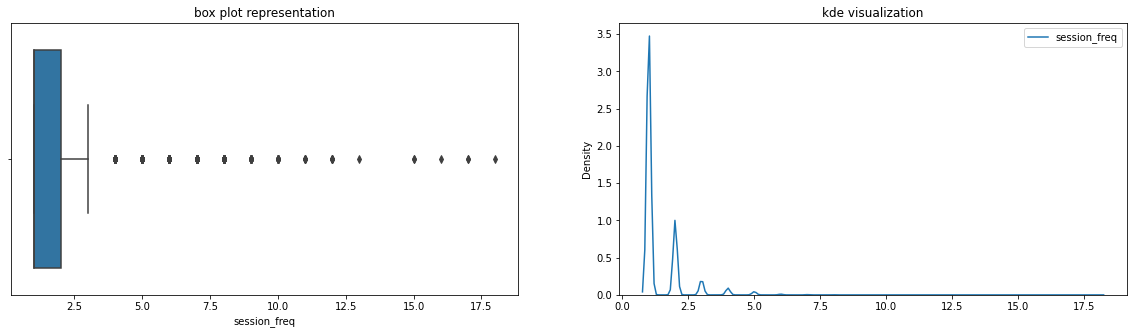

In [44]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_freq']],x="session_freq")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_freq']])

plt.show()

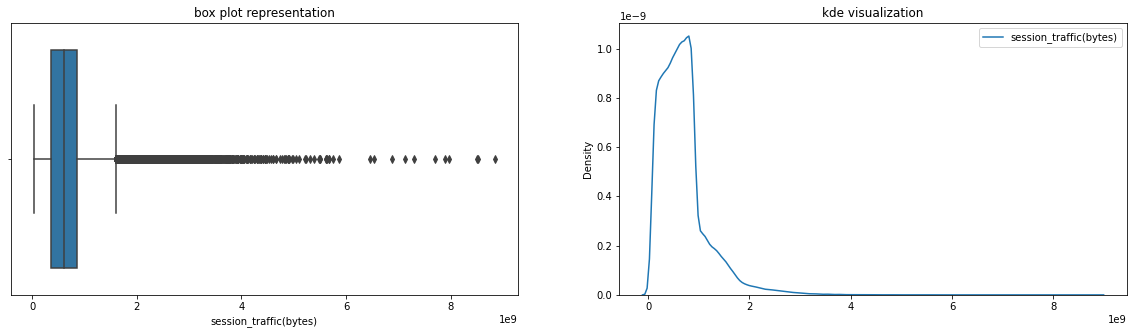

In [45]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_traffic(bytes)']],x="session_traffic(bytes)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_traffic(bytes)']])

plt.show()

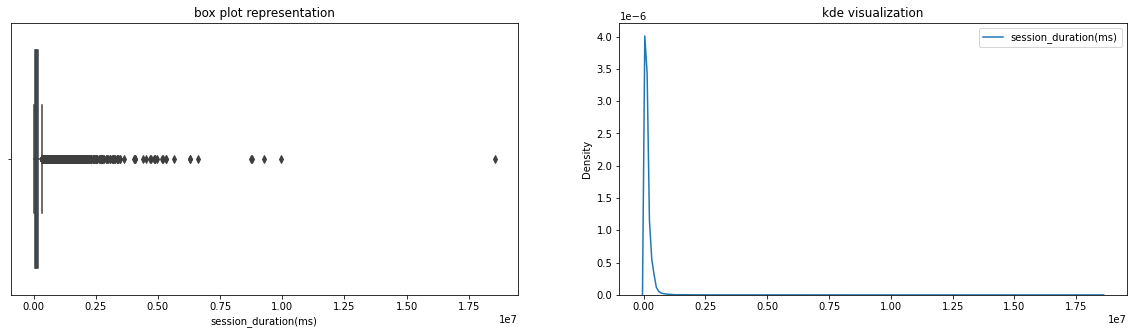

In [46]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=user_engagement[['session_duration(ms)']],x="session_duration(ms)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=user_engagement[['session_duration(ms)']])

plt.show()

handle outliers

In [47]:
cleaned_engagement_metric = cleaner.handle_outliers(user_engagement, 'session_freq')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_duration(ms)')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_traffic(bytes)')
cleaned_engagement_metric2 = cleaned_engagement_metric.copy()
cleaned_engagement_metric

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
3197020876596.0,2.321240e+08,325035.5,1.0
33601001722.0,8.786906e+08,116720.0,1.0
33601001754.0,1.568596e+08,181230.0,1.0
33601002511.0,5.959665e+08,134969.0,1.0
33601007832.0,4.223207e+08,49878.0,1.0
...,...,...,...
33789967113.0,2.081231e+08,160461.0,1.0
33789980299.0,1.094693e+09,210389.0,2.0
33789996170.0,7.146416e+08,8810.0,1.0


Data Distribution after handling outliers

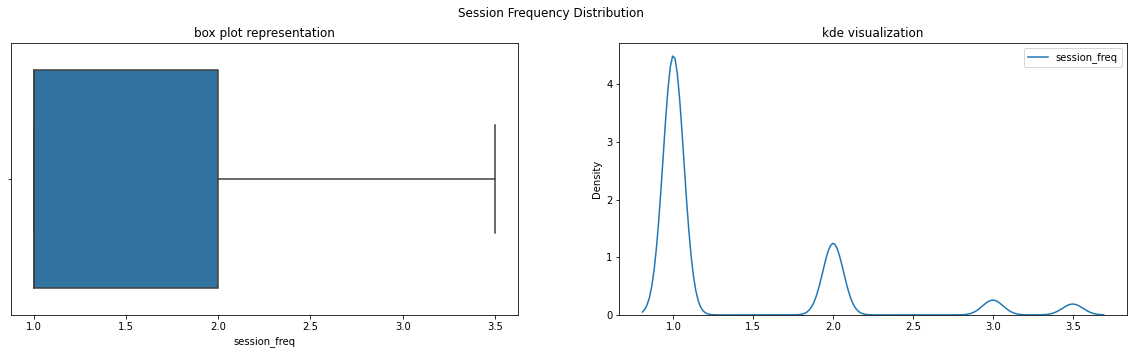

In [48]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_freq']],x="session_freq")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_freq']])

plt.suptitle("Session Frequency Distribution")
plt.show()

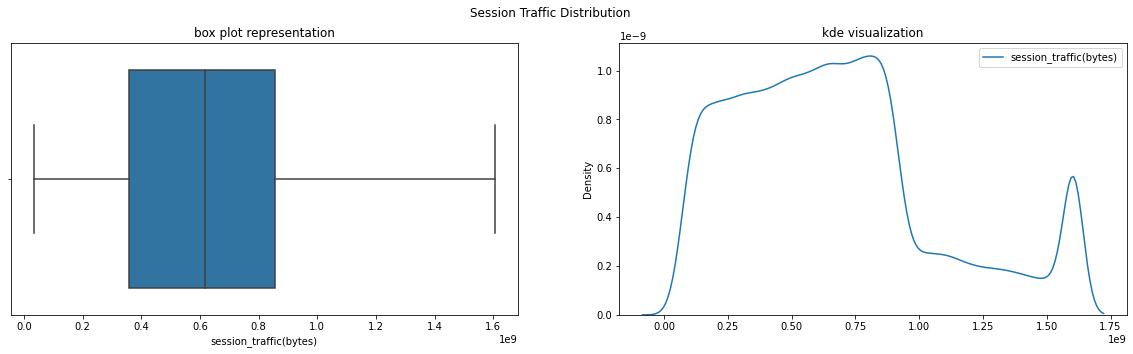

In [49]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_traffic(bytes)']],x="session_traffic(bytes)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_traffic(bytes)']])

plt.suptitle("Session Traffic Distribution")
plt.show()

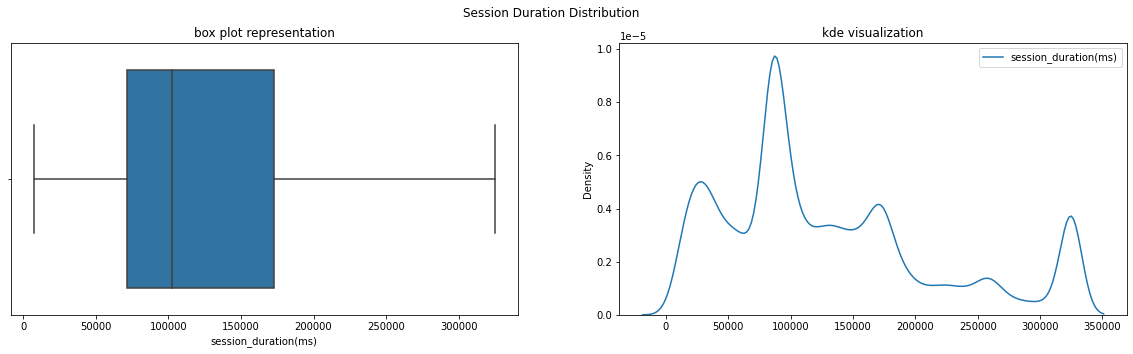

In [50]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1,title="box plot representation")
sns.boxplot(data=cleaned_engagement_metric[['session_duration(ms)']],x="session_duration(ms)")

plt.subplot(1,2,2,title="kde visualization")
sns.kdeplot(data=cleaned_engagement_metric[['session_duration(ms)']])

plt.suptitle("Session Duration Distribution")
plt.show()

as we can see we managed to significantly reduce the skewness of the data

Customer clustering (K-means)
- Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [51]:
# normalize the data
normalized_engagement_metric = cleaner.normalizer(cleaned_engagement_metric)
normalized_engagement_metric

,session_traffic(bytes),session_duration(ms),session_freq
0,0.999999,0.001400,4.308039e-09
1,1.000000,0.000133,1.138057e-09
2,0.999999,0.001155,6.375122e-09
3,1.000000,0.000226,1.677947e-09
4,1.000000,0.000118,2.367869e-09
...,...,...,...
106851,1.000000,0.000771,4.804848e-09
106852,1.000000,0.000192,1.826996e-09
106853,1.000000,0.000012,1.399303e-09
106854,1.000000,0.000294,2.082000e-09


In [52]:
kmeans= KMeans(
    init="k-means++",
    n_clusters= 3,
    n_init= 10,
    max_iter= 300,
    random_state=20  
)

In [53]:
model = kmeans.fit(normalized_engagement_metric)
centroids = kmeans.cluster_centers_

In [54]:
with open("../models/user_engamenet_metric_clustering_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [55]:
cleaned_engagement_metric['cluster'] = model.predict(normalized_engagement_metric)
cleaned_engagement_metric.head()

,session_traffic(bytes),session_duration(ms),session_freq,cluster
msisdn/number,,,,
3197020876596.0,232123971.0,325035.5,1.0,1
33601001722.0,878690574.0,116720.0,1.0,0
33601001754.0,156859643.0,181230.0,1.0,2
33601002511.0,595966483.0,134969.0,1.0,0
33601007832.0,422320698.0,49878.0,1.0,0


In [56]:
cleaned_engagement_metric.columns


Index(['session_traffic(bytes)', 'session_duration(ms)', 'session_freq',
       'cluster'],
      dtype='object')

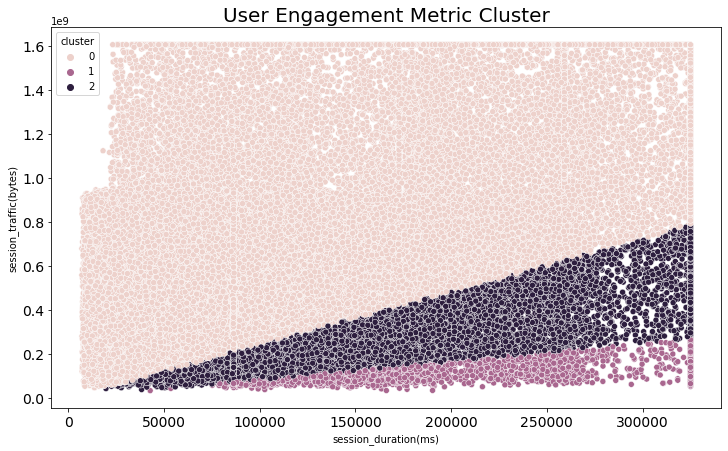

In [57]:
utility.plot_scatter(cleaned_engagement_metric, 'session_duration(ms)', 'session_traffic(bytes)', 'User Engagement Metric Cluster','cluster',None)

Min, Max, average, and total non-normalized metrics for each cluster

In [58]:
cleaned_engagement_metric.describe()

,session_traffic(bytes),session_duration(ms),session_freq,cluster
count,1.068560e+05,106856.000000,106856.000000,106856.000000
mean,6.636263e+08,130253.994394,1.359582,0.317072
std,3.959274e+08,87611.985353,0.653562,0.715009
min,3.324901e+07,7142.000000,1.000000,0.000000
25%,3.585499e+08,71308.000000,1.000000,0.000000
50%,6.179231e+08,102740.000000,1.000000,0.000000
75%,8.574351e+08,172799.000000,2.000000,0.000000
max,1.605763e+09,325035.500000,3.500000,2.000000


In [59]:
cleaned_engagement_metric.groupby('cluster').agg(['min','max','mean','count','var','std'])

session_traffic(bytes)                                     \
                           min           max          mean  count   
cluster                                                             
0                   46047479.0  1.605763e+09  7.470112e+08  88720   
1                   33249009.0  2.683204e+08  1.158779e+08   2391   
2                   38022357.0  7.834343e+08  2.769490e+08  15745   

                                    session_duration(ms)            \
                  var           std                  min       max   
cluster                                                              
0        1.426126e+17  3.776408e+08               7142.0  325035.5   
1        2.056154e+15  4.534483e+07              42856.0  325035.5   
2        2.570157e+16  1.603171e+08              19764.0  325035.5   

                                                          session_freq       \
                  mean  count           var           std          min  max   
cluster                                                                       
0        122077.044663  88720  7.589282e+09  87116.485444          1.0  3.5   
1        195042.424927   2391  5.044288e+09  71023.153474          1.0  2.0   
2        166490.885011  15745  6.236747e+09  78973.076610          1.0  3.5   

                                              
             mean  count       var       std  
cluster                                       
0        1.408493  88720  0.475595  0.689634  
1        1.019239   2391  0.018877  0.137392  
2        1.135662  15745  0.134923  0.367318



Cluster 0<br/>
Contains the largest amount of session counts<br/>
Contains on average the highest amount of session traffic<br/>
This cluster would be ranked as the cluster containing the most engaged users as compared to the other clusters.<br/>
<br/>
Cluster 1<br/>
Users in this cluster have a lower session frequency as compared to the other clusters. Which also means they have lesser amount of session traffic.<br/>
This cluster would be ranked as the cluster containig the least engaged users as compared to the others<br/>
<br/>
Cluster 2<br/>
has the highest session_traffic, it is ranked in the middle according to its data counts<br/>


### Aggregate User total traffic per application
derive the top 10 most engaged users per application


In [60]:
cleaned_df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


In [61]:
# calculate total data (UL and DL) per application

cleaned_df["social_media"] = cleaned_df["social_media_dl_(bytes)"] + cleaned_df['social_media_ul_(bytes)']
cleaned_df["google"] = cleaned_df["google_dl_(bytes)"] + cleaned_df["google_ul_(bytes)"]
cleaned_df['email'] = cleaned_df["email_dl_(bytes)"] + cleaned_df["email_ul_(bytes)"]
cleaned_df['youtube'] = cleaned_df["youtube_dl_(bytes)"] + cleaned_df["youtube_ul_(bytes)"]
cleaned_df['netflix'] = cleaned_df["netflix_dl_(bytes)"] + cleaned_df["netflix_ul_(bytes)"]
cleaned_df["gaming"] = cleaned_df["gaming_dl_(bytes)"] + cleaned_df["gaming_ul_(bytes)"]
cleaned_df['other']= cleaned_df["other_dl_(bytes)"]+ cleaned_df["other_ul_(bytes)"]
cleaned_df['total_data'] = cleaned_df['total_dl_(bytes)'] + cleaned_df['total_ul_(bytes)']

In [62]:
users_app_engagement=cleaned_df[['msisdn/number','social_media','google','email','youtube','netflix','gaming','other','total_data']]
users_app_engagement.rename(columns={"msisdn/number":"msisdn"},inplace=True)
users_app_engagement

C:\Users\Natnael\AppData\Local\Temp\ipykernel_20056\3786541237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_app_engagement.rename(columns={"msisdn/number":"msisdn"},inplace=True)


,msisdn,social_media,google,email,youtube,netflix,gaming,other,total_data
0,33664962239.0,1.570185e+06,2.905912e+06,3.701304e+06,1.835594e+07,1.785519e+07,2.924265e+08,1.805588e+08,3.456294e+08
1,33681854413.0,1.933278e+06,4.414096e+06,9.373850e+05,3.935912e+07,3.556554e+07,6.099208e+08,5.419594e+08,7.071854e+08
2,33760627129.0,1.726277e+06,1.022912e+07,3.363124e+06,3.442524e+07,2.375120e+07,2.299803e+08,4.149084e+08,3.076910e+08
3,33750343200.0,6.574930e+05,1.181176e+07,2.070983e+06,3.653476e+07,1.509259e+07,8.103879e+08,7.618372e+08,8.893527e+08
4,33699795932.0,9.127880e+05,7.748843e+06,2.110349e+06,3.422225e+07,1.753980e+07,5.312370e+08,5.646198e+08,6.076814e+08
...,...,...,...,...,...,...,...,...,...
149996,33650688697.0,3.517065e+06,1.278491e+07,6.908760e+05,2.795510e+07,3.756186e+07,5.358069e+08,1.675193e+07,6.318041e+08
149997,33663449963.0,2.352181e+06,4.415361e+06,2.121718e+06,2.216552e+07,4.064329e+07,6.316281e+08,7.146381e+08,7.057839e+08
149998,33621890103.0,1.260239e+06,6.585469e+06,2.058277e+06,2.451641e+07,1.502970e+07,5.669338e+08,1.324156e+08,6.276986e+08
149999,33619622058.0,8.231090e+05,7.757267e+06,2.850914e+06,1.712251e+07,1.649484e+07,3.550664e+08,8.161200e+08,4.015220e+08


In [63]:
users_app_engagement_grouped=users_app_engagement.groupby('msisdn')

In [64]:
users_app_engagement_rank=users_app_engagement_grouped.sum()

In [65]:
users_app_engagement_rank

,social_media,google,email,youtube,netflix,gaming,other,total_data
msisdn,,,,,,,,
3197020876596.0,7.152240e+05,1.043866e+07,1.520771e+06,1.195990e+07,2.659230e+07,1.780487e+08,4.705265e+08,2.321240e+08
33601001722.0,2.232135e+06,4.389005e+06,1.331362e+06,2.162455e+07,2.718098e+07,8.124587e+08,3.865709e+08,8.786906e+08
33601001754.0,2.660565e+06,5.334863e+06,3.307781e+06,1.243222e+07,1.122176e+07,1.197501e+08,2.817101e+08,1.568596e+08
33601002511.0,3.195623e+06,3.443126e+06,3.205380e+06,2.133357e+07,1.935390e+07,5.388277e+08,5.016937e+08,5.959665e+08
33601007832.0,2.802940e+05,9.678493e+06,2.284670e+06,6.977321e+06,1.942092e+06,3.911261e+08,3.527970e+07,4.223207e+08
...,...,...,...,...,...,...,...,...
33789980299.0,4.250312e+06,1.024647e+07,5.315327e+06,3.801281e+07,5.195031e+07,9.723450e+08,1.075140e+09,1.094693e+09
33789996170.0,3.001830e+05,7.531269e+06,1.006915e+06,2.664784e+07,1.490254e+07,6.603614e+08,2.952828e+08,7.146416e+08
33789997247.0,4.985690e+05,5.429705e+06,2.514097e+06,1.985157e+07,8.531060e+06,4.370033e+08,2.111151e+08,4.803073e+08


### user engagement per app

In [66]:
column_names=sorted(['social_media','google','email','youtube','netflix','gaming'])

for app in column_names:
    print(f"Top 10 {app} Users")
    display(users_app_engagement_rank[[app]].sort_values(by=[app],ascending=False).drop(['nan'],axis=0,inplace=False).head(10) )
    print("---------------------------------")

Top 10 email Users


,email
msisdn,
33626320676.0,42418782.0
33614892860.0,40788634.0
33625779332.0,40633966.0
33786323068.0,36310123.0
33659725664.0,35999792.0
33760536639.0,33693767.0
33675877202.0,31514421.0
33665460546.0,30417885.0
33667163239.0,30335796.0


---------------------------------
Top 10 gaming Users


,gaming
msisdn,
33614892860.0,7.749432e+09
33760536639.0,7.461045e+09
33625779332.0,7.326673e+09
33675877202.0,6.970568e+09
33626320676.0,6.887572e+09
33659725664.0,6.725559e+09
33666464084.0,6.646303e+09
33760413819.0,6.268620e+09
33664712899.0,6.103856e+09


---------------------------------
Top 10 google Users


,google
msisdn,
33626320676.0,152191852.0
33625779332.0,142307915.0
33614892860.0,127973787.0
33760536639.0,123223099.0
33659725664.0,116516345.0
33786323068.0,110254484.0
33675877202.0,109860502.0
33667163239.0,105032696.0
33761268199.0,97089988.0


---------------------------------
Top 10 netflix Users


,netflix
msisdn,
33659725664.0,399519079.0
33614892860.0,361401046.0
33625779332.0,356980607.0
33760536639.0,334643269.0
33626320676.0,328725740.0
33760413819.0,318347546.0
33667163239.0,313939488.0
33675877202.0,309093159.0
33786323068.0,305939790.0


---------------------------------
Top 10 social_media Users


,social_media
msisdn,
33626320676.0,43374779.0
33760536639.0,39783189.0
33659725664.0,35412358.0
33614892860.0,28294544.0
33625779332.0,27135500.0
33667163239.0,24247850.0
33786323068.0,23974919.0
33669068942.0,23800834.0
33603127838.0,23077825.0


---------------------------------
Top 10 youtube Users


,youtube
msisdn,
33625779332.0,452958769.0
33760536639.0,396289198.0
33614892860.0,394370218.0
33626320676.0,374483047.0
33675877202.0,317410572.0
33667163239.0,315231310.0
33627080969.0,308790774.0
33760413819.0,303169107.0
33698792269.0,302661958.0


---------------------------------


### Top 3 most used apps

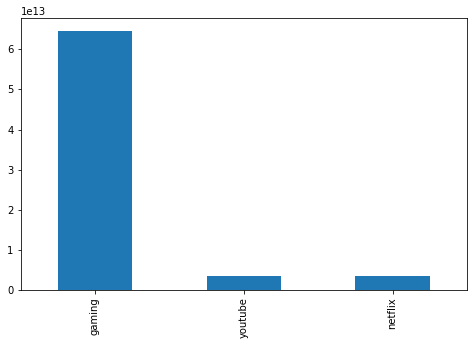

In [75]:
total_user_engagement=users_app_engagement_rank[column_names].agg(['sum'])
plt.figure(figsize=(8,5))
# transpose data to make app names indicies
total_user_engagement=total_user_engagement.T['sum']
bar_df=total_user_engagement.sort_values(ascending=False)[:3]
bar_df.plot(kind='bar')
plt.show()

We're going to use the elbow method to determine the appropriate number of cluster. We're going to run several iterations of K-means and we're going to record the sum of squared errors(SSE)

In [38]:

kmeans_kwargs= {
    'init':"k-means++",
    'n_init': 10,
    'max_iter': 300,
    'random_state':20  
}

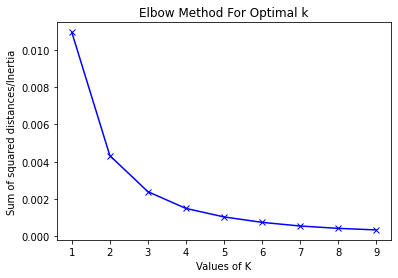

In [39]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters,**kmeans_kwargs)
 kmeans.fit(normalized_engagement_metric)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
# with kneed we can determine the optimum number of clusters
kl = KneeLocator(range(1,10), Sum_of_squared_distances, curve='convex', direction='decreasing')
kl.elbow

3

The elbow method shows us that the sum of the squared errors will decrease the rate of descent after the optimum number of cluster as shown in the plot above. We have verified that the optimum number of cluster is 3 both graphically and programmatically.



In [41]:
cleaned_engagement_metric

,session_traffic(bytes),session_duration(ms),session_freq,cluster
msisdn/number,,,,
3197020876596.0,2.321240e+08,325035.5,1.0,1
33601001722.0,8.786906e+08,116720.0,1.0,0
33601001754.0,1.568596e+08,181230.0,1.0,2
33601002511.0,5.959665e+08,134969.0,1.0,0
33601007832.0,4.223207e+08,49878.0,1.0,0
...,...,...,...,...
33789967113.0,2.081231e+08,160461.0,1.0,2
33789980299.0,1.094693e+09,210389.0,2.0,0
33789996170.0,7.146416e+08,8810.0,1.0,0


In [42]:
centroids.shape

(3, 3)

In [43]:
centroids

array([[9.99999980e-01, 1.72695286e-04, 2.21648452e-09],
       [9.99998254e-01, 1.76521573e-03, 9.98811223e-09],
       [9.99999763e-01, 6.56986400e-04, 5.23451561e-09]])

In [44]:
centroids_df = pd.DataFrame(centroids, columns=['session_traffic(bytes)', 'session_freq', 'session_duration(ms)'])
centroids_df

,session_traffic(bytes),session_freq,session_duration(ms)
0,1.000000,0.000173,2.216485e-09
1,0.999998,0.001765,9.988112e-09
2,1.000000,0.000657,5.234516e-09


In [45]:
kmeans_2 = KMeans(n_clusters=3, init='k-means++').fit(normalized_engagement_metric)
pred = kmeans_2.predict(normalized_engagement_metric)

cleaned_engagement_metric2['cluster'] = pred

In [46]:
distance = kmeans.fit_transform(normalized_engagement_metric)

distance_from_less_engagement = list(map(lambda x : x[0], distance))

cleaned_engagement_metric2['score'] = distance_from_less_engagement

In [47]:
cleaned_engagement_metric2.head()

,session_traffic(bytes),session_duration(ms),session_freq,cluster,score
msisdn/number,,,,,
3197020876596.0,232123971.0,325035.5,1.0,2,0.001210
33601001722.0,878690574.0,116720.0,1.0,1,0.000058
33601001754.0,156859643.0,181230.0,1.0,0,0.000965
33601002511.0,595966483.0,134969.0,1.0,1,0.000036
33601007832.0,422320698.0,49878.0,1.0,1,0.000073


In [48]:
utility.save_data(cleaned_engagement_metric2, '../data/user_engagement_metric.csv',index=True)

Data saved successfully!


In [49]:
agg_data = {}
agg_data['top_ten_per_traffic'] = top_10_per_traffic
agg_data['top_ten_per_freq'] = top_10_per_freq
# agg_data['top_ten_customers_per_metric'] = top_10_customers_per_metric
agg_data['top_ten_per_duration'] = top_10_per_duration
pickle.dump(agg_data, open('../data/engagement_data.pkl', 'wb'))